In [10]:
import argparse
import os
import time
import torch
import numpy as np
from tqdm import tqdm
from scipy.signal import butter, filtfilt

from BioMime.utils.basics import update_config, load_generator
from BioMime.utils.plot_functions import plot_muaps
from BioMime.utils.params import num_mus, steps, tgt_params
from BioMime.models.generator import Generator


In [11]:
cfg = update_config('./config/config.yaml')

generator = Generator(cfg.Model.Generator)
generator = load_generator('ckp/model_linear.pth', generator, 'cuda:0')


In [12]:
# here we generate muaps for N MUs of the same muscle, thus fixing the z
n_mus = 1

zi = torch.randn(1, cfg.Model.Generator.Latent).repeat([n_mus, 1])

In [13]:
zi = zi.cuda()
zi.device

device(type='cuda', index=0)

In [14]:
generator = generator.cuda()

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
cond = torch.rand(n_mus, 6).cuda()
sim = generator.sample(n_mus, cond.float(), cond.device, zi)
#sim1 = generator.cpu().sample(n_mus, cond.float(), cond.device, model.zi)


In [16]:
cond_rep = cond.repeat(100, 1)
print(cond_rep.shape)
sim_rep = sim.unsqueeze(0).repeat(100, 1, 1, 1)

torch.Size([100, 6])


In [17]:
cond

tensor([[0.9953, 0.0121, 0.7702, 0.0735, 0.9172, 0.0245]], device='cuda:0')

In [18]:
class ConditionBiomime(nn.Module):
    def __init__(self, biomime, zi, device='cuda:0'):
        super(ConditionBiomime, self).__init__()

        self.biomime = biomime
        self.biomime = self.biomime.to(device)
        self.zi = zi.to(device)
        self.zi.requires_grad_(False)


    def forward(self, conds):
        n_mus = conds.shape[0]

        return generator.sample(n_mus, conds, conds.device, zi.repeat(n_mus, 1))

biomime_cond = ConditionBiomime(generator, zi, device='cpu')

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

# Optimization Model to find the optimal input
class ConditionOptimizer(nn.Module):
    def __init__(self, biomime, initial_input, zi, indices=[0,1,2,3,4,5], device='cuda:0'):
        super(ConditionOptimizer, self).__init__()
        self.biomime = biomime # Pretrained BioMime network (not trainable here)
        self.biomime = self.biomime.to(device)

        self.indices = indices
        self.opt_params = nn.Parameter(torch.logit(initial_input.clone().detach()[:, indices].requires_grad_(True))) # Optimizable input
        self.biomime_input = torch.logit(initial_input.clone().detach().to(device))
        # opt params only contain the indices
        #self.opt_params = nn.Parameter(initial_input.clone().detach().requires_grad_(True)[:, indices]).to(device)
        self.zi = zi.to(device)
        self.zi.requires_grad_(False)

        self.sig = nn.Sigmoid()


    def forward(self):
        # Pass the input to the BioMime network
        biomime_input = self.biomime_input.clone()

        biomime_input[:, self.indices] = self.opt_params
        
        #biomime_input = self.opt_params

        output = self.biomime.sample(n_mus, self.sig(biomime_input), self.opt_params.device, self.zi)
        return output
    
    def get_conditions(self):
        #self.biomime_input[:, self.indices] = self.opt_params
        return self.sig(self.opt_params)
        #return (self.opt_params)

In [248]:
cond

tensor([[0.7773, 0.5728, 0.2079, 0.9736, 0.1175, 0.5470]], device='cuda:0')

In [22]:
initial_cond = torch.tensor([[0.2, 0.3, 0.6, 0.9736, 0.1175, 0.5470]])#torch.rand(n_mus, 6)
model = ConditionOptimizer(generator, initial_cond.clone().detach(), zi, indices=[0, 1,2], device='cuda:0')

In [23]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# # Optimization Model to find the optimal input
# class ConditionOptimizer(nn.Module):
#     def __init__(self, biomime, initial_input, zi, device='cuda:0'):
#         super(ConditionOptimizer, self).__init__()
#         self.biomime = biomime # Pretrained BioMime network (not trainable here)
#         self.biomime = self.biomime.to(device)
#         self.opt_params = nn.Parameter(initial_input.clone().detach().requires_grad_(True)) # Optimizable input
#         self.zi = zi.to(device)
#         self.zi.requires_grad_(False)

#         self.sig = nn.Sigmoid()


#     def forward(self):
#         # Pass the input to the BioMime network
#         output = self.biomime.sample(n_mus*100, self.sig(self.opt_params), self.opt_params.device, self.zi)
#         return output
    
#     def get_conditions(self):
#         return self.sig(self.opt_params)
#         #return (self.opt_params)

In [24]:
def optimize_input(model,  target_output, device='cuda:0', lr=0.01, steps=1000):
    """
    Optimize the input to the BioMime network to match a target output.
    
    Args:
        biomime: Pretrained BioMime model.
        initial_input: Initial guess for the 6D input (torch Tensor).
        target_output: Desired output to optimize for.
        lr: Learning rate.
        steps: Number of optimization steps.

    Returns:
        Optimized input tensor.
    """
    # Initialize the optimizer model
    model = model.to(device)
    target_output = target_output.to(device)
    optimizer = optim.Adam([model.opt_params], lr=lr)
    criterion = nn.MSELoss()  # Loss function

    inter_conds = []

    # Optimization loop
    for step in range(steps):
        optimizer.zero_grad()
        output = model.forward()
        loss = criterion(output, target_output)
        loss.backward()
        optimizer.step()

        # ensure that params are in [0,1]
        # with torch.no_grad():
        #     model.opt_params.data = torch.clip(model.opt_params.data, 0.0, 1.0)

        # Print progress
        if (step + 1) % 2 == 0:
            with torch.no_grad():
                #x_loss = torch.square(model.get_conditions() - cond) 
                #x_loss = x_loss.sum(axis=1)
                # arg_min = x_loss.argmin()
                # loss_min = x_loss.min()
            #print(f"Step [{step+1}/{steps}], Loss: {loss.item():.4f}, X loss {loss_min.item():.4f}, argmin {arg_min.item()}")
                opt_params = model.get_conditions()[0]
                print(f"Step [{step+1}/{steps}], Loss: {loss.item():.4f}, x1: {opt_params[0].item():.4f} x2:{opt_params[1].item():.4f} ")

        inter_conds.append(model.get_conditions().detach().cpu().numpy())

    print("Optimization finished!")
    return model.get_conditions(), inter_conds

In [25]:
_, conds = optimize_input(model.cuda(), sim.detach() , device='cuda', lr=1e-1, steps=4000)

Step [2/4000], Loss: 12.2743, x1: 0.2326 x2:0.3379 
Step [4/4000], Loss: 12.2736, x1: 0.2608 x2:0.3703 
Step [6/4000], Loss: 12.2725, x1: 0.2807 x2:0.4081 
Step [8/4000], Loss: 12.2727, x1: 0.2905 x2:0.4434 
Step [10/4000], Loss: 12.2699, x1: 0.2832 x2:0.4864 
Step [12/4000], Loss: 12.2706, x1: 0.2811 x2:0.5202 
Step [14/4000], Loss: 12.2705, x1: 0.2754 x2:0.5498 
Step [16/4000], Loss: 12.2705, x1: 0.2672 x2:0.5726 
Step [18/4000], Loss: 12.2706, x1: 0.2613 x2:0.5858 
Step [20/4000], Loss: 12.2706, x1: 0.2553 x2:0.5940 
Step [22/4000], Loss: 12.2705, x1: 0.2488 x2:0.5976 
Step [24/4000], Loss: 12.2705, x1: 0.2431 x2:0.5971 
Step [26/4000], Loss: 12.2703, x1: 0.2399 x2:0.5908 
Step [28/4000], Loss: 12.2702, x1: 0.2382 x2:0.5798 
Step [30/4000], Loss: 12.2702, x1: 0.2383 x2:0.5698 
Step [32/4000], Loss: 12.2703, x1: 0.2382 x2:0.5631 
Step [34/4000], Loss: 12.2703, x1: 0.2393 x2:0.5633 
Step [36/4000], Loss: 12.2703, x1: 0.2423 x2:0.5667 
Step [38/4000], Loss: 12.2703, x1: 0.2457 x2:0.572

KeyboardInterrupt: 

In [42]:
training_conds = np.vstack(conds)
print(training_conds.shape)

NameError: name 'conds' is not defined

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_conditions(time_data, correct_values):
    """
    Plots the time evolution of six conditions against their correct values.

    Parameters:
        time_data (numpy.ndarray): An Nx6 array representing the time evolution of 6 conditions.
        correct_values (numpy.ndarray): A 1x6 array of correct values to plot against.
    """
    if not isinstance(time_data, np.ndarray) or not isinstance(correct_values, np.ndarray):
        raise TypeError("Both time_data and correct_values must be NumPy arrays.")

    if time_data.shape[1] != 6:
        raise ValueError("time_data must have 6 columns (conditions).")

    if correct_values.shape != (6,):
        raise ValueError("correct_values must be a 1D NumPy array of size 6.")

    time_steps = np.arange(time_data.shape[0])

    # Create subplots for better comparison
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))
    axes = axes.flatten()

    for i in range(6):
        axes[i].plot(time_steps, time_data[:, i], label=f"Condition {i + 1}")
        axes[i].axhline(correct_values[i], color='r', linestyle='--', label="Correct Value")
        axes[i].set_title(f"Condition {i + 1}")
        axes[i].set_xlabel("Time Step")
        axes[i].set_ylabel("Value")
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# time_data = np.random.rand(100, 6)  # Replace with actual time evolution data
# correct_values = np.array([1, 0.5, 1.2, 0.8, 1.5, 1.0])
# plot_conditions(time_data, correct_values)

plot_conditions(training_conds, cond.detach().cpu().numpy().reshape(-1))

NameError: name 'training_conds' is not defined

In [17]:
conds_pred

NameError: name 'conds_pred' is not defined

In [18]:
cond

tensor([[0.1423, 0.9152, 0.3586, 0.2557, 0.8187, 0.8761]], device='cuda:0')

In [19]:
results = torch.square(conds_pred.cpu()- cond).detach().numpy()

NameError: name 'conds_pred' is not defined

In [20]:
import seaborn as sns

sns.heatmap(results)

NameError: name 'results' is not defined

In [230]:
muaps = model.to('cpu').forward().cpu()

mse = torch.square(muaps - torch.tensor(sim))

In [236]:
mse.max()

tensor(21819.7871, grad_fn=<MaxBackward1>)

In [231]:
tensor_flat = mse.view(-1)

# Get the top 20 maximum values and their indices
top_values, top_indices = torch.topk(tensor_flat, 20)

# Convert the flat indices back to the original 4D indices
original_indices = torch.unravel_index(top_indices, mse.shape)

In [232]:
mse.sum(axis=1).shape

torch.Size([20, 10, 32])

<Axes: >

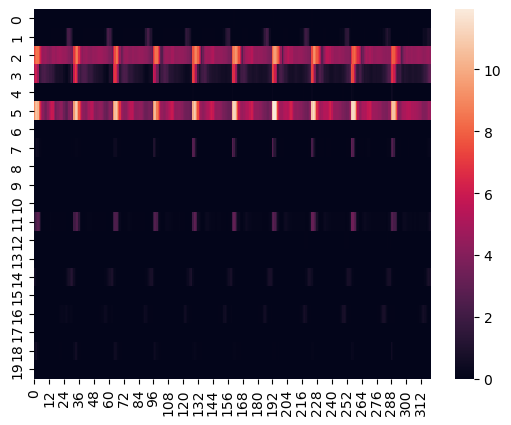

In [259]:
mse1 = mse.sum(axis=1).reshape(20,-1).detach().numpy()

sns.heatmap(np.log(mse1 + 1.))

In [239]:
sim.shape

(20, 96, 10, 32)

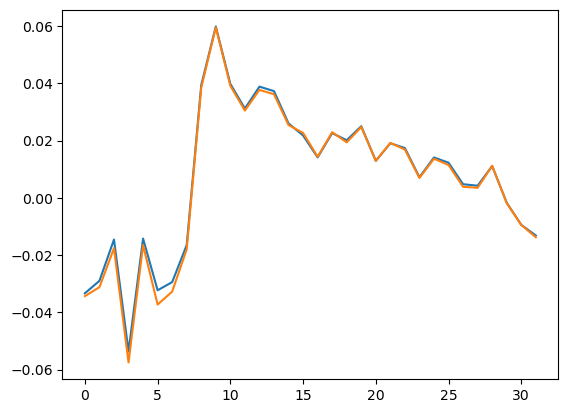

In [273]:
m_index = 11
electrode_i = 0
electrode_j = 0

plt.plot(sim[m_index][:][electrode_i][electrode_j])
plt.plot(muaps.detach().numpy()[m_index][:][electrode_i][electrode_j])

(20, 96, 10, 32)
[0]


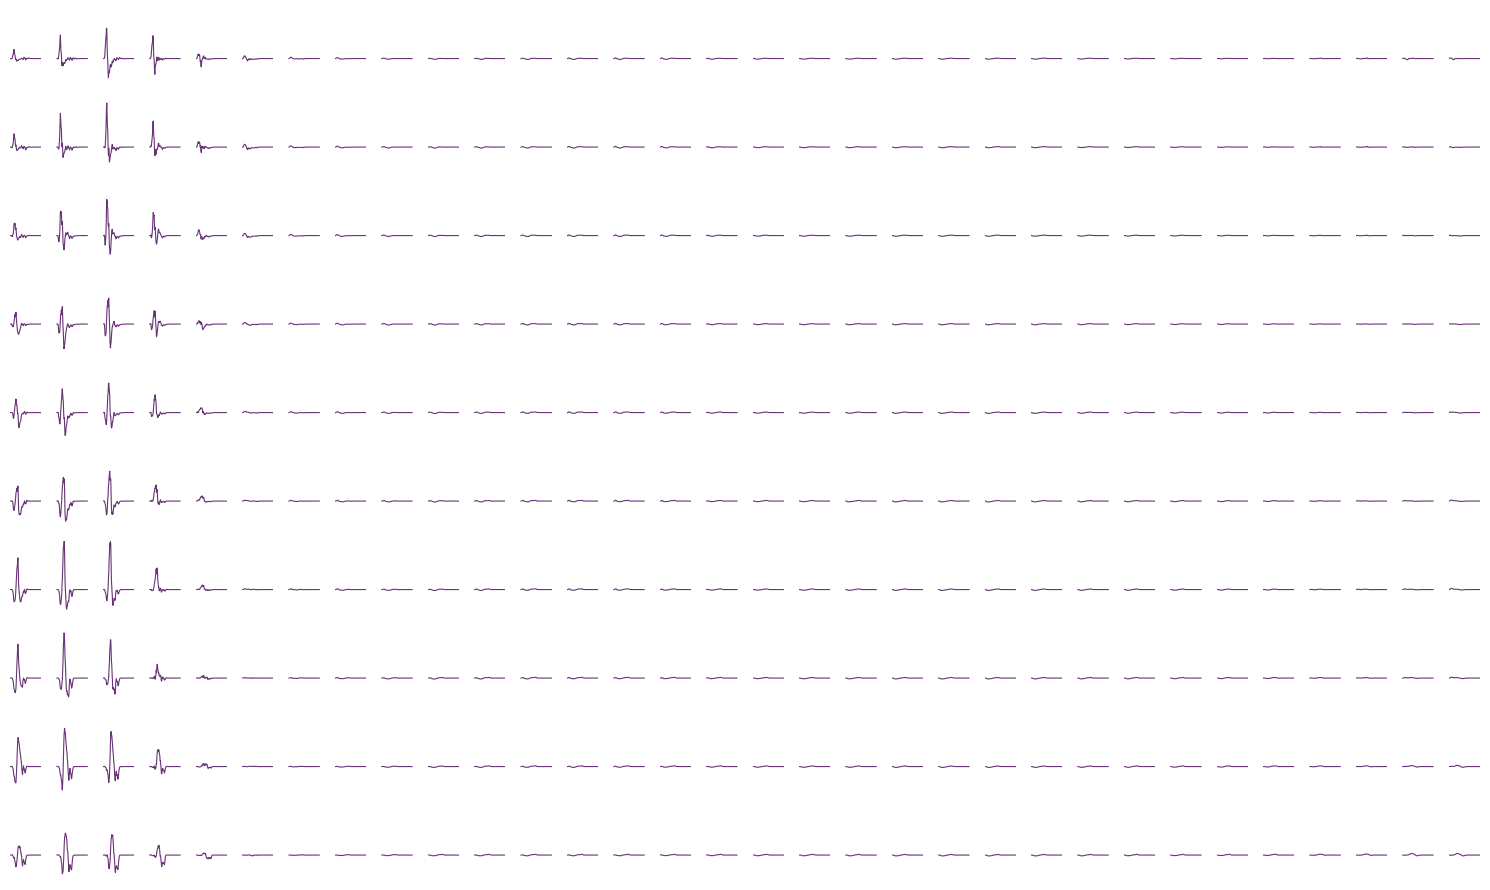

In [271]:
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt

from easydict import EasyDict as edict
from matplotlib.collections import LineCollection

def plot_muaps(muaps, path, mu_indices=[], step_indices=[], suffix='ms', svg=False, cfg=None):
    """
    muaps: [arr]
    """

    if cfg == None:
        cfg = edict({'cmap': 'viridis', 'figsize': [15, 9], 'linewidth': 0.8, 'alpha': 0.8})

    if not isinstance(muaps, np.ndarray):
        muaps = muaps.numpy()

    num_muaps, steps, n_row, n_col, n_t = muaps.shape
    x_ = np.linspace(0, 1, n_t)
    cmap = plt.get_cmap(cfg.cmap)
    colors = []
    if len(step_indices) == 0:
        step_indices = np.arange(steps)
    for i in np.linspace(1, 0, len(step_indices)):
        colors.append(list(cmap(i)[:3]))

    if len(mu_indices) == 0:
        mu_indices = np.arange(num_muaps)
        print(mu_indices)
    for i in mu_indices:
        cur_muaps = -muaps[i]
        p_max_amp = np.max(cur_muaps[:])
        n_max_amp = np.min(cur_muaps[:])
        fig, axes = plt.subplots(n_row, n_col, figsize=tuple(cfg.figsize))
        for row in range(n_row):
            for col in range(n_col):
                segs = [np.column_stack([x_, cur_muaps[sp, row, col]]) for sp in step_indices]
                line_segments = LineCollection(segs, array=x_, colors=None, linewidths=(cfg.linewidth), alpha=cfg.alpha)
                axes[row, col].add_collection(line_segments)
                axes[row, col].set_ylim([n_max_amp, p_max_amp])
                axes[row, col].set_axis_off()
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(path, '{}_muap_{}.jpg'.format(suffix, i)))
        if svg:
            plt.savefig(os.path.join(path, '{}_muap_{}.svg'.format(suffix, i)))
        plt.close()




from easydict import EasyDict as edict
# torch.Size([5, 256, 6, 2, 4])
#zi = torch.randn(num_mus, cfg.Model.Generator.Latent)
#sim = generator.sample(num_mus, cond.float(), cond.device)
print(sim.shape)
sim_trans = sim.transpose(0, 2, 3, 1)
sim_muaps = np.array([sim_trans[11:12]])
plot_muaps(sim_muaps, '.')


[0]


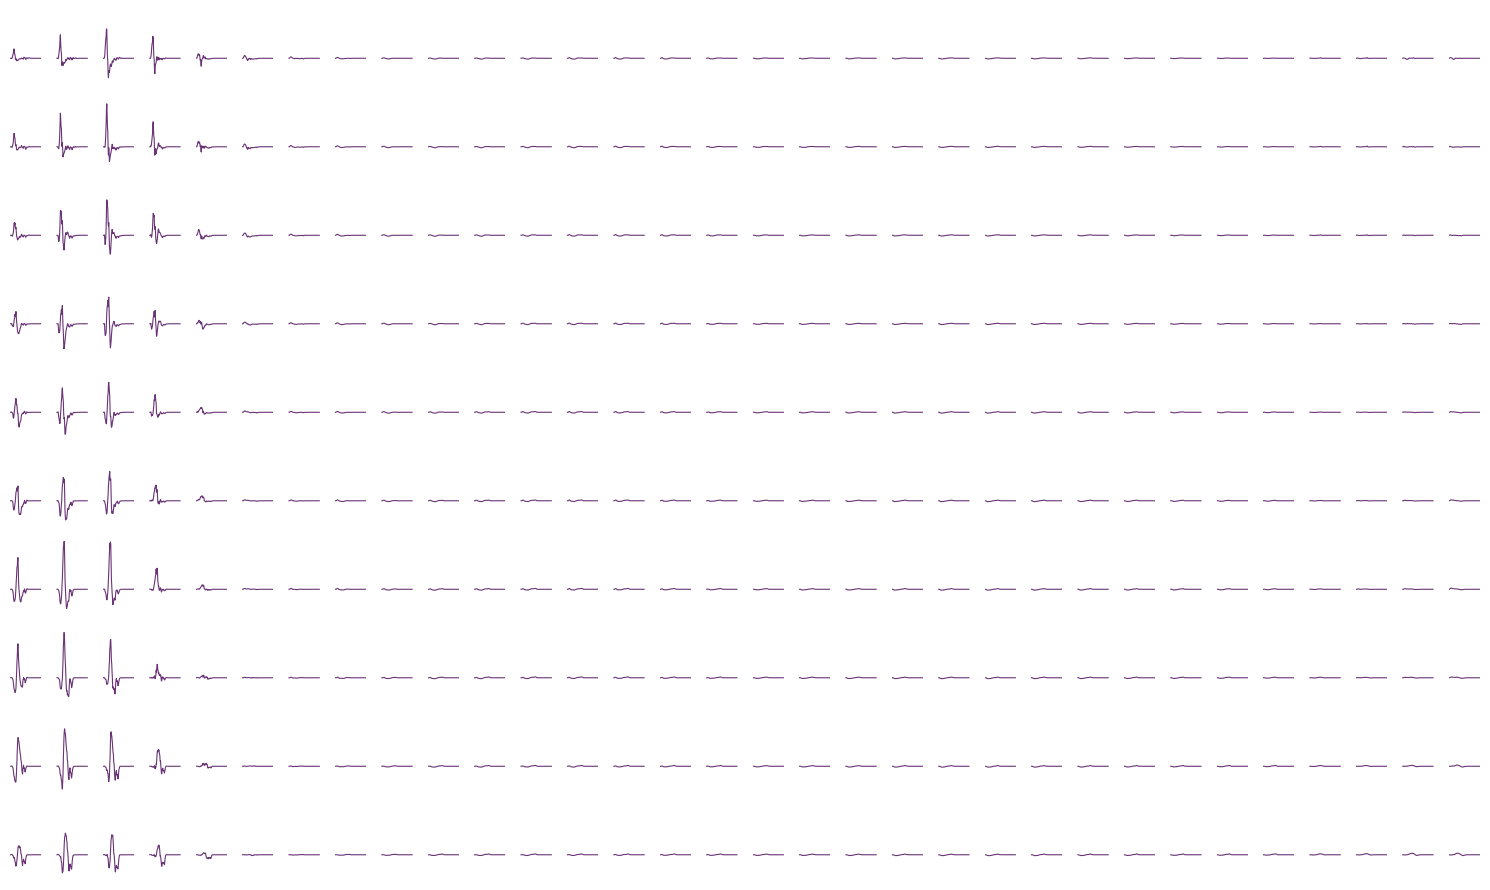

In [272]:
from easydict import EasyDict as edict
# torch.Size([5, 256, 6, 2, 4])
#zi = torch.randn(num_mus, cfg.Model.Generator.Latent)
#sim = generator.sample(num_mus, cond.float(), cond.device)
sim_trans = muaps.detach().numpy().transpose(0, 2, 3, 1)
sim_muaps = np.array([sim_trans[11:12]])
plot_muaps(sim_muaps, '.')


In [216]:
sim = sim.transpose(0, 2, 3, 1)

In [215]:
sim.shape

(20, 32, 96, 10)

In [170]:
mse.argmax(keepdim=True)

tensor([[[[162753]]]])

In [171]:
mse.flatten()[162753]

tensor(21819.7871, grad_fn=<SelectBackward0>)

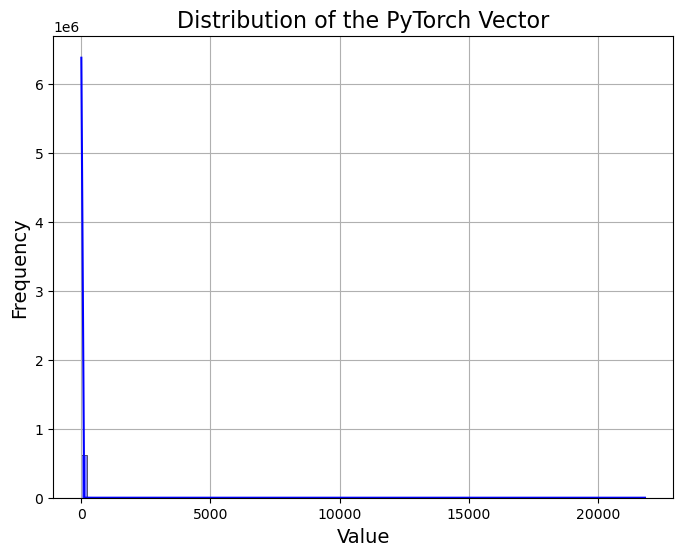

In [163]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a PyTorch vector (example)
vector = mse.flatten().detach()  # A vector with 1000 random values from a normal distribution

# Convert the PyTorch tensor to a NumPy array
vector_np = vector.numpy()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(vector_np, bins=100, kde=True, color='blue', edgecolor='black')
plt.title('Distribution of the PyTorch Vector', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True)
plt.show()


In [21]:

#cond = torch.rand(n_mus, 6).cuda()
sim = generator.cuda().sample(n_mus, cond.float().cuda(), 'cuda', zi)

In [22]:
cond.device

device(type='cuda', index=0)

In [257]:
import numpy as np

def create_tensor_with_grid(initial_tensor, i, j, N):
    """
    Creates an NxN,6 tensor where columns i and j contain a grid of values 
    (linspace between 0 and 1), and other columns retain values from the initial tensor.

    Parameters:
        initial_tensor (numpy.ndarray): A 1x6 tensor containing initial values.
        i (int): The index of the first column to be replaced with the grid.
        j (int): The index of the second column to be replaced with the grid.
        N (int): The size of the grid (NxN).

    Returns:
        numpy.ndarray: An NxN,6 tensor with the specified modifications.
    """
    # Create a linspace between 0 and 1 for the grid
    linspace_values = np.linspace(0, 1, N)
    grid_i, grid_j = np.meshgrid(linspace_values, linspace_values)

    # Create an NxN,6 tensor by broadcasting the initial tensor
    result_tensor = np.tile(initial_tensor, (N, N, 1))

    # Replace the i and j columns with the grid values
    result_tensor[..., i] = grid_i
    result_tensor[..., j] = grid_j

    return result_tensor

# Example usage

N = 51  # Grid size

result = create_tensor_with_grid(cond.cpu().numpy(), 1, 2, N)
print(result)


[[[0.77730393 0.         0.         0.9735876  0.11747533 0.54703695]
  [0.77730393 0.02       0.         0.9735876  0.11747533 0.54703695]
  [0.77730393 0.04       0.         0.9735876  0.11747533 0.54703695]
  ...
  [0.77730393 0.96       0.         0.9735876  0.11747533 0.54703695]
  [0.77730393 0.98       0.         0.9735876  0.11747533 0.54703695]
  [0.77730393 1.         0.         0.9735876  0.11747533 0.54703695]]

 [[0.77730393 0.         0.02       0.9735876  0.11747533 0.54703695]
  [0.77730393 0.02       0.02       0.9735876  0.11747533 0.54703695]
  [0.77730393 0.04       0.02       0.9735876  0.11747533 0.54703695]
  ...
  [0.77730393 0.96       0.02       0.9735876  0.11747533 0.54703695]
  [0.77730393 0.98       0.02       0.9735876  0.11747533 0.54703695]
  [0.77730393 1.         0.02       0.9735876  0.11747533 0.54703695]]

 [[0.77730393 0.         0.04       0.9735876  0.11747533 0.54703695]
  [0.77730393 0.02       0.04       0.9735876  0.11747533 0.54703695]
  [0

In [258]:
sim.shape

torch.Size([96, 10, 32])

In [259]:
c#ond = torch.tensor([[0.4, 0.2, 0.8, 0.6, 0.4, 0.2]])

NameError: name 'c' is not defined

In [260]:
result = result.reshape(-1, 6)
result.shape

(2601, 6)

In [261]:
torch.cuda.empty_cache()

bsize = 51
total = N*N
result_batched = result.reshape(-1, bsize, 6)
all_res = []
for i in tqdm(range(result_batched.shape[0])):
    all_res.append(biomime_cond(torch.tensor(result_batched[i]).cuda()).detach().cpu().numpy())

100%|██████████| 51/51 [00:03<00:00, 13.44it/s]


In [263]:
torch.tensor(result_batched[i]).cuda().shape

torch.Size([51, 6])

In [223]:
hmap = np.stack(all_res)

In [224]:
hmap = hmap.reshape(N*N, 96, 10, 32)

In [225]:
ll = torch.square((torch.tensor(hmap) - sim.cpu()).sum(axis=[3])).sum(axis=[1,2])

In [226]:
ll_log = torch.log(ll + 1.)

<Axes: >

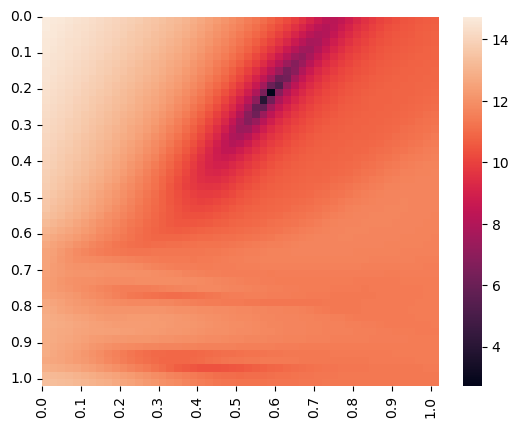

In [240]:
import seaborn as sns


def heatmap_with_linspace(heatmap, N):
    """
    Creates a heatmap of the log likelihoods with custom linspace labels.

    Parameters:
        heatmap (torch.Tensor): A 1D tensor containing the log likelihood values.
        N (int): The size of the grid (NxN).

    Returns:
        seaborn.matrix.ClusterGrid: A Seaborn ClusterGrid object containing the heatmap.
    """
    import seaborn as sns
    import numpy as np

    # Create a Seaborn heatmap
    ax = sns.heatmap(heatmap.reshape(N, N).detach().cpu().numpy())
    ax.set_xticks(np.arange(0, 51, 5))  # Adjust tick positions for clarity
    ax.set_yticks(np.arange(0, 51, 5))
    linspace = np.linspace(0, 1, 51)

    ax.set_xticklabels(np.round(linspace[::5], 1))  # Set the custom linspace labels
    ax.set_yticklabels(np.round(linspace[::5], 1))

    return ax

heatmap_with_linspace(ll_log, N)

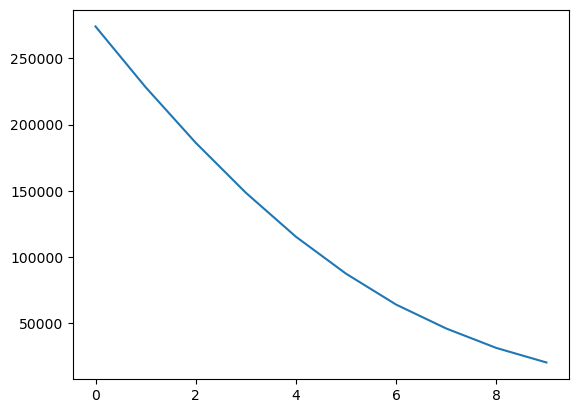

In [228]:
import matplotlib.pyplot as plt

ll_res = ll.reshape(N, N)

plt.plot(ll_res[10][15:25].detach().cpu().numpy())
plt.show()

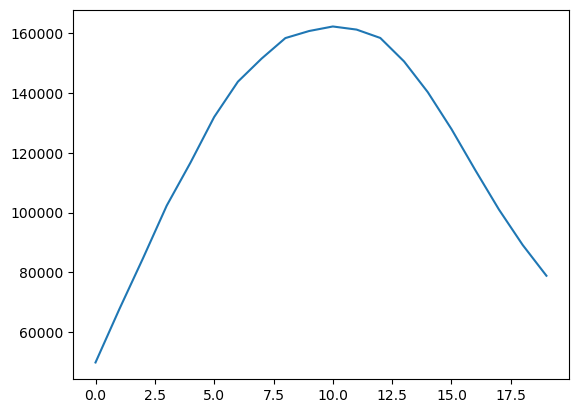

In [252]:
import matplotlib.pyplot as plt

ll_res = ll.reshape(N, N)

plt.plot(ll_res[0:20,20].detach().cpu().numpy())
plt.show()

In [253]:
ll_res[20, 40]

tensor(3782792.2500, grad_fn=<SelectBackward0>)

In [254]:
ll_res.argmin()

tensor(2060)

In [255]:
min_value = ll_res.min()
min_index = ll_res.argmin()
min_indices = np.unravel_index(min_index, ll_res.shape)

print(f"Minimum value: {min_value}")
print(f"Indices of minimum value: {min_indices}")

Minimum value: 4.87890977618477e-19
Indices of minimum value: (40, 20)
